In [274]:
# @title
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [275]:
# @title
current_dir =  "/content/gdrive/My Drive/Colab Notebooks/Thesis/Clustering"
import os
import glob
import numpy as np
import pickle
import spacy
import re
import pickle
from collections import defaultdict


os.chdir(current_dir)

!pip install -U spacy
!python -m spacy download en_core_web_sm
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Get Psychopath Texts and Control Texts

In [276]:
import re
# @title
directories = [
    "/content/gdrive/My Drive/Colab Notebooks/Thesis/murderers",
    "/content/gdrive/My Drive/Colab Notebooks/Thesis/corporate",
    "/content/gdrive/My Drive/Colab Notebooks/Thesis/politicians",
]


psych_texts = {}

# Iterate over each directory
for directory in directories:
    # List all files in the directory
    files = os.listdir(directory)
    # Filter out only the .txt files
    txt_files = [file for file in files if file.endswith('.txt')]
    # Now you can work with each .txt file in this directory
    for txt_file in txt_files:
        # Open each .txt file
        with open(os.path.join(directory, txt_file), 'r') as file:
            # Read the contents of the file
            content = file.read()
            # Do whatever you need with the content
        txt_file = re.split('_|\.', txt_file)[0]
        psych_texts[txt_file] = content
        print(txt_file)

wayne
carl
bundy
bernardo
dahmer
gacy
kemper
mitchell
ridgeway
bennett
sells
bittaker
marsh
manson
fastow
skilling
madoff
maxwell
dunlap
murdoch
bankmanfried
lay
ebbers
jfk
reagan
fdr
clinton
gwb
eisenhower
lbj
ford
carter
hwb
truman
hoover
cruz
sanders
trump
nixon


In [277]:
# @title
control_dir = "/content/gdrive/My Drive/Colab Notebooks/Thesis/control"
files = os.listdir(control_dir)
# Filter out only the .txt files
control_txts = [file for file in files if file.endswith('.txt')]

users = defaultdict(list)

for txt_file in control_txts:
        id = re.findall(r'\d\d\d\d', txt_file)[0]
        # Open each .txt file
        with open(os.path.join(control_dir, txt_file), 'r') as file:
            # Read the contents of the file
            content = file.read()
            # Do whatever you need with the content
        users[id].append(content)


def extract_controls(text):
    # Remove everything between <IVER> and <IVER>, including the markers themselves
    cleaned_text = re.sub(r'<IVER>.*?<IVER>', '', text, flags=re.DOTALL)

    # Remove all remaining angle brackets and any characters between them
    cleaned_text = re.sub(r'<[^>]*>', '', cleaned_text)

    # Remove duplicate spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)

    return cleaned_text


control_texts = {} #collect the extracted control texts
for id, texts in users.items():
  control_texts[id] = extract_controls(" ".join(texts))
  print(id)



1101
1001
1501
0601
0301
1301
2301
1901
2401
2201
2801
2901
3001
3601
3301
3501
3401
3201
3801
4001


In [278]:
print(control_texts.keys())
print(psych_texts.keys())

combine = {} #combine psych texts and control texts with id's as keys
combine.update(control_texts)
combine.update(psych_texts)

dict_keys(['1101', '1001', '1501', '0601', '0301', '1301', '2301', '1901', '2401', '2201', '2801', '2901', '3001', '3601', '3301', '3501', '3401', '3201', '3801', '4001'])
dict_keys(['wayne', 'carl', 'bundy', 'bernardo', 'dahmer', 'gacy', 'kemper', 'mitchell', 'ridgeway', 'bennett', 'sells', 'bittaker', 'marsh', 'manson', 'fastow', 'skilling', 'madoff', 'maxwell', 'dunlap', 'murdoch', 'bankmanfried', 'lay', 'ebbers', 'jfk', 'reagan', 'fdr', 'clinton', 'gwb', 'eisenhower', 'lbj', 'ford', 'carter', 'hwb', 'truman', 'hoover', 'cruz', 'sanders', 'trump', 'nixon'])


## Preprocessing

In [279]:
import re
import string
import spacy

# Load your spaCy model here, you can change this to any model you prefer
nlp = spacy.load('en_core_web_sm')

class TextProcessor:
    def __init__(self):
        # Dictionary of contractions and their replacements
        self.contractions = {
            r"\bwanna\b": "want to",
            r"\bhafta\b": "have to",
            r"\bkinda\b": "kind of",
            r"\byknow\b": "you know",
            r"\buseta\b": "used to",
            r"\bsorta\b": "sort of",
        }
        self.modified_punctuation = string.punctuation.replace("'", "")

    def replace_contractions(self, text):
        # Replace each contraction with its corresponding replacement
        for contraction, replacement in self.contractions.items():
            text = re.sub(contraction, replacement, text)
        return text

    def custom_tokenize(self, text):
        doc = nlp(text)
        hits = []
        for token in doc:
            pos = token.pos_
            text = token.text.lower()
            lemma = token.lemma_
            if pos == "NUM":
                hits.append(f"{pos}_{pos}")
            elif pos == 'DET' and text == 'a':
                hits.append("an_DET")
            else:
                hits.append(f"{lemma}_{pos}")
        return hits

    def preprocess(self, text):
        # Remove unwanted punctuation
        clean_text = ''.join(char for char in text if char not in self.modified_punctuation)
        # Replace newline characters with spaces
        clean_text = clean_text.replace("\n", " ")
        # Replace multiple spaces with a single space
        clean_text = ' '.join(clean_text.split())
        clean_text = self.replace_contractions(clean_text)
        return self.custom_tokenize(clean_text)



processor = TextProcessor() #instantiate
clean_data = {k: processor.preprocess(v) for k,v in combine.items()} #clean

print(clean_data.keys())


dict_keys(['1101', '1001', '1501', '0601', '0301', '1301', '2301', '1901', '2401', '2201', '2801', '2901', '3001', '3601', '3301', '3501', '3401', '3201', '3801', '4001', 'wayne', 'carl', 'bundy', 'bernardo', 'dahmer', 'gacy', 'kemper', 'mitchell', 'ridgeway', 'bennett', 'sells', 'bittaker', 'marsh', 'manson', 'fastow', 'skilling', 'madoff', 'maxwell', 'dunlap', 'murdoch', 'bankmanfried', 'lay', 'ebbers', 'jfk', 'reagan', 'fdr', 'clinton', 'gwb', 'eisenhower', 'lbj', 'ford', 'carter', 'hwb', 'truman', 'hoover', 'cruz', 'sanders', 'trump', 'nixon'])


In [280]:
print([i for i in clean_data.values()][0:2])

[['it_PRON', 'be_AUX', 'like_INTJ', 'right_INTJ', 'yeah_INTJ', 'and_CCONJ', 'it_PRON', 'be_AUX', 'uh_INTJ', 'and_CCONJ', 'it_PRON', 'be_AUX', 'not_PART', 'too_ADV', 'bad_ADJ', 'because_SCONJ', 'I_PRON', 'have_VERB', 'to_PART', 'scratch_VERB', 'off_ADP', 'your_PRON', 'ticket_NOUN', 'you_PRON', 'give_VERB', 'I_PRON', 'yeah_INTJ', 'they_PRON', 'will_AUX', 'not_PART', 'bother_VERB', 'it_PRON', 'green_ADJ', 'bay_PROPN', 'packer_NOUN', 'oh_INTJ', 'my_INTJ', 'gosh_INTJ', 'yeah_INTJ', 'they_PRON', 'go_VERB', 'and_CCONJ', 'win_VERB', 'the_DET', 'super_ADJ', 'bowl_NOUN', 'and_CCONJ', 'they_PRON', 'go_VERB', 'back_ADV', 'and_CCONJ', 'lose_VERB', 'the_DET', 'super_ADJ', 'bowl_NOUN', 'so_ADV', 'just_ADV', 'watch_VERB', 'it_PRON', 'and_CCONJ', 'uh_INTJ', 'you_PRON', 'know_VERB', 'they_PRON', 'lose_VERB', 'yesterday_NOUN', 'yeah_INTJ', 'so_ADV', 'where_SCONJ', 'be_AUX', 'you_PRON', 'out_ADP', 'of_ADP', 'uh_INTJ', 'overseas_ADJ', 'oh_INTJ', 'man_NOUN', 'by_ADP', 'time_NOUN', 'you_PRON', 'get_VERB', 't

# Function Words

In [281]:
from collections import Counter




class TextFWAnalyzer:
    def __init__(self):
        self.counter = Counter()
        self.filtered = []

    def count_tokens(self, data):
        """Counts the frequency of each token in the dataset."""
        for tokens in data.values():
            self.counter.update(tokens)

    def filter(self, data, fw_tags, num_items):
        """Processes the text data based on filter settings, updates internal state."""
        # Count the tokens in the provided data
        self.count_tokens(data)

        # Retrieve the most common tokens up to num_items
        top = self.counter.most_common(num_items)

        # Filter tokens based on specific part-of-speech tags
        self.filtered = [item[0] for item in top if item[0].split("_")[1] in fw_tags]

    def get_fw(self):
        """Returns the list of function words filtered in the last operation."""
        return self.filtered

    def display_results(self, top_items):
        """Prints the filtered tokens and the top items not in the filtered list."""
        print("Filtered tokens:")
        for token in self.filtered:
            print(token)
        print(f"Number of filtered items: {len(self.filtered)}\n")

        print("Remaining top items not filtered:")
        for item in top_items:
            if item[0] not in self.filtered:
                print(item)


analyzer = TextFWAnalyzer()
fw_tags = ["PRON", "DET", "PART", "CCONJ", "SCONJ", "ADP", "AUX", "INTJ"]
analyzer.filter(clean_data, fw_tags, 100)
function_words = analyzer.get_fw()

print("Function Words:")
print(function_words)
print(len(function_words))

Function Words:
['be_AUX', 'I_PRON', 'and_CCONJ', 'the_DET', 'an_DET', 'it_PRON', 'you_PRON', 'uh_INTJ', 'of_ADP', 'not_PART', 'to_PART', 'they_PRON', 'in_ADP', 'that_PRON', 'we_PRON', 'do_AUX', 'he_PRON', 'but_CCONJ', 'to_ADP', 'that_SCONJ', 'have_AUX', 'on_ADP', 'my_PRON', 'for_ADP', 'with_ADP', 'what_PRON', 'she_PRON', 'um_INTJ', 'yeah_INTJ', 'would_AUX', 'or_CCONJ', 'because_SCONJ', 'there_PRON', 'at_ADP', 'like_ADP', 'if_SCONJ', 'about_ADP', 'out_ADP', 'when_SCONJ', 'that_DET', 'like_INTJ', 'up_ADP', 'will_AUX', 'well_INTJ', 'can_AUX', 'from_ADP', 'this_DET', 'all_DET', 'this_PRON', 'could_AUX', 'who_PRON', 'something_PRON', 'where_SCONJ', 'their_PRON', 'no_DET', 'how_SCONJ', 'into_ADP', 'some_DET', 'as_ADP', 'as_SCONJ', 'your_PRON', 'our_PRON', 'by_ADP']
63


## Divide

In [282]:
class DocumentSplitter:
    def __init__(self, data, length):
        """
        Initializes the DocumentSplitter class with dictionary data and a specified length.

        Parameters:
            data (dict): A dictionary where both keys and values are strings.
            length (int): The fixed length to which the string values should be divided.
        """
        self.data = data
        self.length = length
        self.new_dict = {}
        self._split_docs()  # Perform the splitting during initialization

    def _split_docs(self):
        """
        Splits the string values in the dictionary into sublists of the given length,
        with new keys generated for each substring. This private method populates self.new_dict.
        """
        for key, value in self.data.items():
            num_substrings = len(value) // self.length + (1 if len(value) % self.length != 0 else 0)
            for i in range(num_substrings):
                start_index = i * self.length
                end_index = start_index + self.length
                new_key = f"{key}_{i+1}"
                self.new_dict[new_key] = value[start_index:end_index]

    def filter(self):
        """
        Retrieves items where the substring length equals the specified length.

        Returns:
            dict: A dictionary with items of the specified full length.
        """
        return {k: v for k, v in self.new_dict.items() if len(v) == self.length}

    def leftovers(self):
        """
        Retrieves items where the substring length is less than the specified length.

        Returns:
            dict: A dictionary with items that are not of the full specified length.
        """
        return {k: v for k, v in self.new_dict.items() if len(v) != self.length}



In [283]:
docs = DocumentSplitter(clean_data, 600).filter() #train data
leftovers = DocumentSplitter(clean_data, 600).leftovers() #test data
print(len(docs))

76


In [284]:
print(docs.keys())

dict_keys(['1101_1', '1001_1', '1001_2', '1001_3', '1501_1', '1501_2', '1501_3', '0601_1', '1301_1', '1301_2', '1301_3', '2301_1', '1901_1', '1901_2', '1901_3', '2401_1', '2401_2', '2201_1', '2801_1', '2801_2', '2901_1', '2901_2', '3001_1', '3601_1', '3301_1', '3301_2', '3501_1', '3501_2', '3501_3', '3401_1', '3401_2', '3201_1', '3201_2', '3801_1', '3801_2', '3801_3', '4001_1', '4001_2', 'wayne_1', 'bundy_1', 'bundy_2', 'bernardo_1', 'bernardo_2', 'bernardo_3', 'dahmer_1', 'dahmer_2', 'gacy_1', 'gacy_2', 'kemper_1', 'kemper_2', 'mitchell_1', 'mitchell_2', 'ridgeway_1', 'ridgeway_2', 'marsh_1', 'marsh_2', 'manson_1', 'fastow_1', 'madoff_1', 'murdoch_1', 'bankmanfried_1', 'jfk_1', 'reagan_1', 'clinton_1', 'lbj_1', 'hwb_1', 'truman_1', 'hoover_1', 'hoover_2', 'cruz_1', 'sanders_1', 'trump_1', 'trump_2', 'trump_3', 'nixon_1', 'nixon_2'])


In [285]:
class StringProcessor: #make it easy to get categories for individual documents
    def __init__(self):
        """
        Initialize the StringProcessor with a default dictionary.
        You can later modify this dictionary directly or by using the set_lookup_dict method.
        """

        self.lookup_dict = {'hwb': 'pl', 'truman': 'pl', 'hoover': 'pl', 'sanders': 'pl', 'nixon': 'pl', 'carter': 'pl', 'trump': 'ph', 'jfk': 'ph', 'reagan': 'ph', 'fdr': 'ph', 'clinton': 'ph', 'gwb': 'ph', 'eisenhower': 'ph', 'lbj': 'ph', 'ford': 'ph', 'cruz': 'ph', 'fastow': 'c', 'skilling': 'c', 'madoff': 'c', 'maxwell': 'c', 'dunlap': 'c', 'murdoch': 'c', 'bankmanfried': 'c', 'lay': 'c', 'ebbers': 'c', 'wayne': 'fl', 'carl': 'fl', 'bundy': 'fl', 'bernardo': 'fl', 'dahmer': 'fl', 'gacy': 'fl', 'kemper': 'fl', 'mitchell': 'fl', 'ridgeway': 'fl', 'bennett': 'fl', 'sells': 'fl', 'bittaker': 'fl', 'marsh': 'fl', 'manson': 'fl', '1101': 'h', '1001': 'h', '1501': 'h', '0601': 'h', '0301': 'h', '1301': 'h', '2301': 'h', '1901': 'h', '2401': 'h', '2201': 'h', '2801': 'h', '2901': 'h', '3001': 'h', '3601': 'h', '3301': 'h', '3501': 'h', '3401': 'h', '3201': 'h', '3801': 'h', '4001': 'h'}


    def lookup(self, key):
        """
        Look up a key in the dictionary after processing it with get_name, and return the matching value.

        :param key: The key to be looked up in the dictionary.
        :return: The value associated with the key in the dictionary, or None if the key is not found.
        """
        processed_key = self.get_name(key)
        return self.lookup_dict.get(processed_key, None)

    def get_name(self, input_string):
        """
        Returns the first segment of the input string split by an underscore.

        :param input_string: The string to split and process.
        :return: The first segment of the split string, or the entire string if no underscore is present.
        """
        return input_string.split("_")[0]

# Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


n_samples: 38, n_features: 63
['be_aux' 'i_pron' 'and_cconj' 'the_det' 'an_det' 'it_pron' 'you_pron'
 'uh_intj' 'of_adp' 'not_part' 'to_part' 'they_pron' 'in_adp' 'that_pron'
 'we_pron' 'do_aux' 'he_pron' 'but_cconj' 'to_adp' 'that_sconj' 'have_aux'
 'on_adp' 'my_pron' 'for_adp' 'with_adp' 'what_pron' 'she_pron' 'um_intj'
 'yeah_intj' 'would_aux' 'or_cconj' 'because_sconj' 'there_pron' 'at_adp'
 'like_adp' 'if_sconj' 'about_adp' 'out_adp' 'when_sconj' 'that_det'
 'like_intj' 'up_adp' 'will_aux' 'well_intj' 'can_aux' 'from_adp'
 'this_det' 'all_det' 'this_pron' 'could_aux' 'who_pron' 'something_pron'
 'where_sconj' 'their_pron' 'no_det' 'how_sconj' 'into_adp' 'some_det'
 'as_adp' 'as_sconj' 'your_pron' 'our_pron' 'by_adp']
N=38 documents with V=63 features.


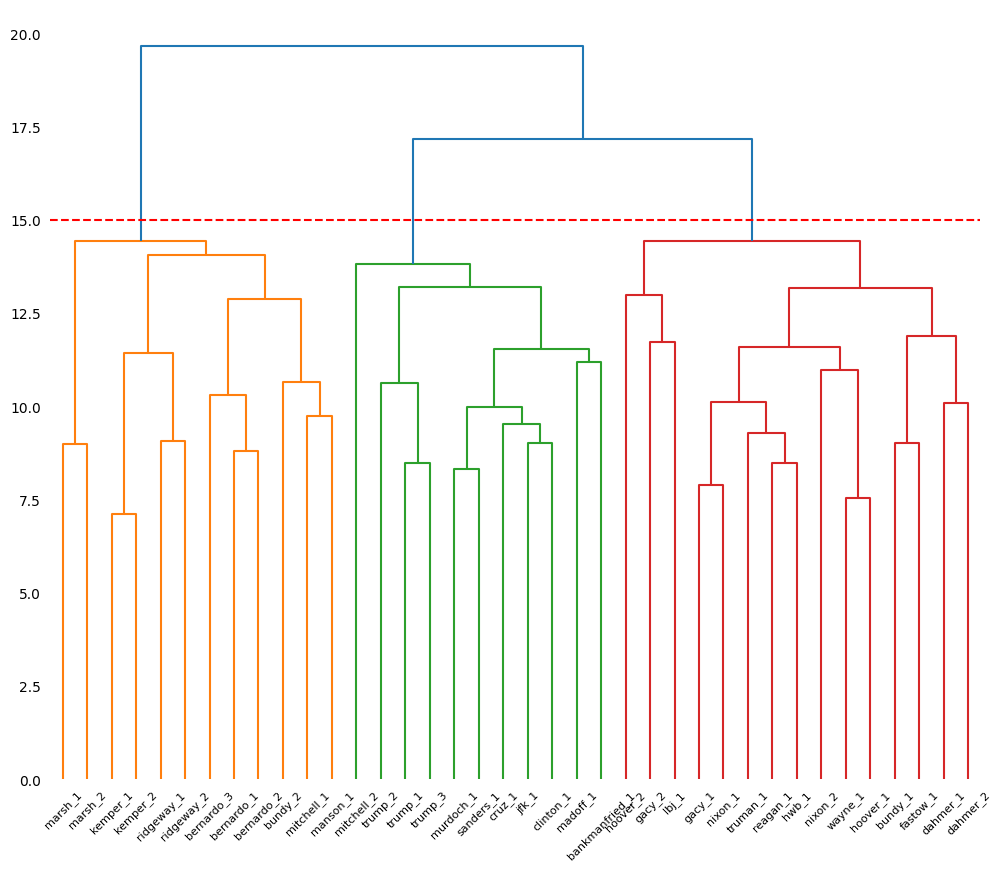

Cluster 1: ['bundy_2', 'bernardo_1', 'bernardo_2', 'bernardo_3', 'kemper_1', 'kemper_2', 'mitchell_1', 'ridgeway_1', 'ridgeway_2', 'marsh_1', 'marsh_2', 'manson_1']
Cluster 2: ['mitchell_2', 'madoff_1', 'murdoch_1', 'bankmanfried_1', 'jfk_1', 'clinton_1', 'cruz_1', 'sanders_1', 'trump_1', 'trump_2', 'trump_3']
Cluster 3: ['wayne_1', 'bundy_1', 'dahmer_1', 'dahmer_2', 'gacy_1', 'gacy_2', 'fastow_1', 'reagan_1', 'lbj_1', 'hwb_1', 'truman_1', 'hoover_1', 'hoover_2', 'nixon_1', 'nixon_2']
cluster labels [3 3 1 1 1 1 3 3 3 3 1 1 1 2 1 1 1 1 1 3 2 2 2 2 3 2 3 3 3 3 3 2 2 2 2 2 3
 3]


In [286]:
processor = StringProcessor()


just_psy = ["ph", "pl", "c", "fl"]

include = just_psy  #what categories to include in the clustering



labels = []
data = []
# Filter and process documents based on inclusion criteria
for document, text in docs.items():
      if processor.lookup(document) in include:
        data.append(" ".join(text))
        labels.append(document)

from sklearn import preprocessing
import scipy.spatial.distance as scidist
import scipy.cluster.hierarchy as hierarchy
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = CountVectorizer(analyzer='word', tokenizer=str.split, vocabulary=[i.lower() for i in function_words], stop_words=None)

X = vectorizer.fit_transform(data)
print(f"n_samples: {X.shape[0]}, n_features: {X.shape[1]}")
print(vectorizer.get_feature_names_out())


v_documents = X.toarray()
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1')
scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(f'N={v_documents.shape[0]} documents with V={v_documents.shape[1]} features.')

authors = labels
#authors = cat_labels

# Categories mapped to each author


# Calculate pairwise distances
dm = scidist.pdist(v_documents, 'euclidean')


# Establish branch structure
linkage_object = hierarchy.linkage(dm, method='ward')

cutoff = 15  # Example cutoff
cluster_labels = fcluster(linkage_object, cutoff, criterion='distance')

# Plot dendrogram
def plot_tree(linkage_object, labels, figsize=(12, 10), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    hierarchy.dendrogram(linkage_object, labels=authors, ax=ax, color_threshold=cutoff,
                          leaf_font_size=8, leaf_rotation=45)
    plt.axhline(y=cutoff, color='r', linestyle='--')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.show()

plot_tree(linkage_object, labels)

# Print clusters
clusters = {i: [] for i in np.unique(cluster_labels)}
for doc_index, cluster_id in enumerate(cluster_labels):
    clusters[cluster_id].append(authors[doc_index])

for cluster, documents in clusters.items():
    print(f"Cluster {cluster}: {documents}")

print(f"cluster labels {cluster_labels}")

# PCA

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


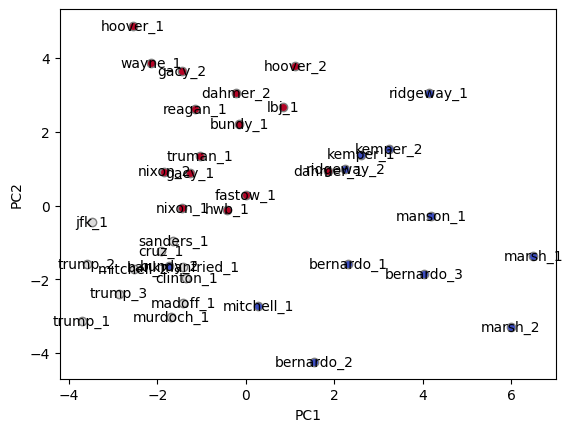

Sorted by PC1:
                      PC1       PC2
not_part        0.281497 -0.084119
do_aux          0.266895 -0.047021
i_pron          0.255180  0.114376
like_adp        0.238077 -0.045521
yeah_intj       0.210803 -0.131680
like_intj       0.207233 -0.108058
my_pron         0.202250  0.192954
what_pron       0.199832 -0.067798
about_adp       0.167964 -0.097607
she_pron        0.159353  0.069212
your_pron       0.156546 -0.104232
it_pron         0.139296 -0.128965
something_pron  0.094133  0.022674
um_intj         0.085749  0.063722
how_sconj       0.080257 -0.023672
that_det        0.080191  0.258609
or_cconj        0.076154 -0.056282
into_adp        0.076012  0.021138
could_aux       0.055159  0.125675
you_pron        0.047297 -0.218688
to_part         0.047018  0.073523
where_sconj     0.045359  0.101838
this_pron       0.043599 -0.201676
out_adp         0.040324  0.123854
well_intj       0.022339  0.073884
all_det         0.017981 -0.078373
at_adp          0.013196  0.220182
on_a

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.decomposition
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
import pandas as pd


cluster_dict = {1: clusters[1], 2: clusters[2], 3: clusters[3]} #input clusters


def plot_pca_from_dict(cluster_dict):
    # Assume docs is a global variable in your code
    global docs

    # Prepare data for PCA
    for_pca = {k: v for k, v in docs.items() if k in chain.from_iterable(cluster_dict.values())}
    X1 = vectorizer.fit_transform([" ".join(i) for i in for_pca.values()])
    v1_documents = X1.toarray()
    v1_documents = preprocessing.normalize(v1_documents.astype(np.float64), 'l1')
    v1_documents = preprocessing.StandardScaler().fit_transform(v1_documents)

    # Perform PCA
    pca = sklearn.decomposition.PCA(n_components=2)
    documents_proj = pca.fit_transform(v1_documents)

    # Prepare authors and colors
    authors = [i for i in for_pca.keys()]
    num_clusters = len(cluster_dict)

    colors = plt.cm.coolwarm(np.linspace(0, 1, num_clusters))  # C

    # Plotting
    fig, ax = plt.subplots()
    for cluster_key, color in zip(cluster_dict.keys(), colors):
      cluster_data = cluster_dict[cluster_key]
      for author in cluster_data:
        author_index = authors.index(author)
        ax.scatter(documents_proj[author_index, 0], documents_proj[author_index, 1], edgecolor='grey', color=color)
        ax.text(documents_proj[author_index, 0], documents_proj[author_index, 1], author, fontsize=10, ha='center', va='center', color='black')


    ax.set(xlabel='PC1', ylabel='PC2')
    plt.show()

    loadings = pca.components_
    feature_names = vectorizer.get_feature_names_out()
    loading_matrix = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)
    sorted_loadings_PC1 = loading_matrix.sort_values(by='PC1', ascending=False)
    sorted_loadings_PC2 = loading_matrix.sort_values(by='PC2', ascending=False)
    print("Sorted by PC1:\n", sorted_loadings_PC1[0:60])
    print("Sorted by PC2:\n", sorted_loadings_PC2[0:60])

    return

# Example usage
# Assume docs and cluster_dict are defined globally in your code
plot_pca_from_dict(cluster_dict)




In [20]:
print(cluster_dict)

{1: ['bundy_2', 'bernardo_1', 'bernardo_2', 'bernardo_3', 'kemper_1', 'kemper_2', 'mitchell_1', 'ridgeway_1', 'ridgeway_2', 'marsh_1', 'marsh_2', 'manson_1'], 2: ['mitchell_2', 'madoff_1', 'murdoch_1', 'bankmanfried_1', 'jfk_1', 'clinton_1', 'cruz_1', 'sanders_1', 'trump_1', 'trump_2', 'trump_3'], 3: ['wayne_1', 'bundy_1', 'dahmer_1', 'dahmer_2', 'gacy_1', 'gacy_2', 'fastow_1', 'reagan_1', 'lbj_1', 'hwb_1', 'truman_1', 'hoover_1', 'hoover_2', 'nixon_1', 'nixon_2']}


#Logistic Regression

 #Just Psychopaths
 #Cluster 1 (felons) vs. Cluster 2 (mix hp and corporate)

In [58]:
for k,v in cluster_dict.items():
  print(f"Cluster {k}:" ,v)#has the document names organized by their HAC cluster

Cluster 1: ['bundy_2', 'bernardo_1', 'bernardo_2', 'bernardo_3', 'kemper_1', 'kemper_2', 'mitchell_1', 'ridgeway_1', 'ridgeway_2', 'marsh_1', 'marsh_2', 'manson_1']
Cluster 2: ['mitchell_2', 'madoff_1', 'murdoch_1', 'bankmanfried_1', 'jfk_1', 'clinton_1', 'cruz_1', 'sanders_1', 'trump_1', 'trump_2', 'trump_3']
Cluster 3: ['wayne_1', 'bundy_1', 'dahmer_1', 'dahmer_2', 'gacy_1', 'gacy_2', 'fastow_1', 'reagan_1', 'lbj_1', 'hwb_1', 'truman_1', 'hoover_1', 'hoover_2', 'nixon_1', 'nixon_2']


In [260]:
clus1 = 2 #select cluster from above
clus2 = 3 #select cluster from above


In [261]:
import pandas as pd

cl1 = pd.DataFrame({'document': cluster_dict[clus1],
                     'text': [docs[name] for name in cluster_dict[clus1]],
                     'label': 1})
cl2 = pd.DataFrame({'document': cluster_dict[clus2],
                     'text': [docs[name] for name in cluster_dict[clus2]],
                     'label': 0})

# prepare dataframe

In [262]:
combined_df = pd.concat([cl1, cl2], axis=0) #combine

In [263]:
print(combined_df)

          document                                               text  label
0       mitchell_2  [free_ADJ, it_PRON, be_AUX, just_ADV, as_SCONJ...      1
1         madoff_1  [you_PRON, know_VERB, when_SCONJ, we_PRON, sho...      1
2        murdoch_1  [uh_INTJ, basically_ADV, it_PRON, be_AUX, very...      1
3   bankmanfried_1  [you_PRON, know_VERB, it_PRON, it_PRON, be_AUX...      1
4            jfk_1  [in_ADP, the_DET, 1st_ADJ, place_NOUN, I_PRON,...      1
5        clinton_1  [Most_ADJ, people_NOUN, think_VERB, you_PRON, ...      1
6           cruz_1  [I_PRON, I_PRON, laugh_VERB, out_ADP, loud_ADJ...      1
7        sanders_1  [Elon_PROPN, Musk_PROPN, now_ADV, own_VERB, Tw...      1
8          trump_1  [okay_INTJ, thank_VERB, you_PRON, very_ADV, mu...      1
9          trump_2  [there_PRON, be_VERB, no_DET, Democrat_PROPN, ...      1
10         trump_3  [thing_NOUN, dead_ADJ, people_NOUN, so_ADV, de...      1
0          wayne_1  [my_PRON, very_ADV, first_ADJ, contemplation_N...      0

In [264]:
features = [i.lower() for i in function_words] #original entire feature set (63 function words)


In [265]:
print(combined_df["document"])

0         mitchell_2
1           madoff_1
2          murdoch_1
3     bankmanfried_1
4              jfk_1
5          clinton_1
6             cruz_1
7          sanders_1
8            trump_1
9            trump_2
10           trump_3
0            wayne_1
1            bundy_1
2           dahmer_1
3           dahmer_2
4             gacy_1
5             gacy_2
6           fastow_1
7           reagan_1
8              lbj_1
9              hwb_1
10          truman_1
11          hoover_1
12          hoover_2
13           nixon_1
14           nixon_2
Name: document, dtype: object


In [270]:
import pandas as pd

# remove duplicate authors in each cluster ex: Bernardo_1, Bernardo_2, Bernardo_3

# Create a new column by splitting the 'label' field
combined_df['label_split'] = combined_df['document'].apply(lambda x: x.split('_')[0])

# Removing duplicates based on the 'label_split' and 'label' columns
df_unique = combined_df.drop_duplicates(subset=['label_split', 'label'])

# Dropping the temporary 'label_split' column
df_unique = df_unique.drop(columns=['label_split'])

# Resetting the index of df_unique
df_unique = df_unique.reset_index(drop=True)

print(df_unique)



          document                                               text  label
0       mitchell_2  [free_ADJ, it_PRON, be_AUX, just_ADV, as_SCONJ...      1
1         madoff_1  [you_PRON, know_VERB, when_SCONJ, we_PRON, sho...      1
2        murdoch_1  [uh_INTJ, basically_ADV, it_PRON, be_AUX, very...      1
3   bankmanfried_1  [you_PRON, know_VERB, it_PRON, it_PRON, be_AUX...      1
4            jfk_1  [in_ADP, the_DET, 1st_ADJ, place_NOUN, I_PRON,...      1
5        clinton_1  [Most_ADJ, people_NOUN, think_VERB, you_PRON, ...      1
6           cruz_1  [I_PRON, I_PRON, laugh_VERB, out_ADP, loud_ADJ...      1
7        sanders_1  [Elon_PROPN, Musk_PROPN, now_ADV, own_VERB, Tw...      1
8          trump_1  [okay_INTJ, thank_VERB, you_PRON, very_ADV, mu...      1
9          wayne_1  [my_PRON, very_ADV, first_ADJ, contemplation_N...      0
10         bundy_1  [yes_INTJ, that_PRON, be_AUX, true_ADJ, I_PRON...      0
11        dahmer_1  [hey_INTJ, you_PRON, be_AUX, lucky_ADJ, you_PR...      0

In [271]:
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Example texts and labels
exp_texts = df_unique["text"]  # get texts
exp_labels = df_unique["label"]  # get labels

# Initialize CountVectorizer
vectorizer_lr = CountVectorizer(vocabulary=features, tokenizer=str.split, analyzer='word')  # instantiate vectorizer for logreg


# Fit and transform the texts
X_lr = vectorizer_lr.fit_transform(([" ".join(i) for i in exp_texts]))

X_lr = X_lr.toarray()

X_lr = preprocessing.normalize(X_lr.astype(np.float64), 'l1')
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the document-term matrix using the scaler
X_scaled = scaler.fit_transform(X_lr)

# Initialize Logistic Regression model
model = LogisticRegression(penalty='l1', solver='liblinear')  # instantiate model

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialize lists to store true labels, predicted labels, and document names
true_labels = [i for i in exp_labels]
predicted_labels = []
predicted_documents = []  # list to store document names for each prediction

# Convert labels to NumPy array
labels_array = exp_labels.to_numpy()


# Perform LOOCV
for train_index, test_index in loo.split(X_scaled):
    # Split the data into training and test sets
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = labels_array[train_index], labels_array[test_index]

    # Document names for the test set
    doc_test = df_unique.iloc[test_index]['document'].values[0]  # directly get the test document name

    # Fit the model on the training data
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probability of '1'
    # Making binary predictions
    y_pred = model.predict(X_test)

    # Predict the label for the test data
    y_pred = model.predict(X_test)

    # Append predicted label to list
    predicted_labels.append(y_pred[0])
    # Append the document name for the prediction
    predicted_documents.append(doc_test)

    # Fetching feature names
    feature_names = vectorizer_lr.get_feature_names_out()
    feature_values = X_test

    # Print the test document name, the feature vectors, and the corresponding label
    #print("Document Name:", doc_test)
    #print("Feature Names and Values:", list(zip(feature_names, feature_values[0])))
    #if y_pred[0] != y_test[0]:
    print("Document Name:", doc_test)
    print("Transformed Log Odds:", y_pred_prob[0])
    print("Predicted:", y_pred[0])
    print("Label:", y_test[0])

    print("\n")

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)


from sklearn.metrics import accuracy_score, classification_report

print(f"LOOCV Accuracy: {accuracy}")
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))





Document Name: mitchell_2
Transformed Log Odds: 0.573813601386307
Predicted: 1
Label: 1


Document Name: madoff_1
Transformed Log Odds: 0.7649050841732317
Predicted: 1
Label: 1


Document Name: murdoch_1
Transformed Log Odds: 0.8571120704285315
Predicted: 1
Label: 1


Document Name: bankmanfried_1
Transformed Log Odds: 0.7229291770954855
Predicted: 1
Label: 1


Document Name: jfk_1
Transformed Log Odds: 0.7737783645025507
Predicted: 1
Label: 1


Document Name: clinton_1
Transformed Log Odds: 0.7309423231085546
Predicted: 1
Label: 1


Document Name: cruz_1
Transformed Log Odds: 0.35512788842685317
Predicted: 0
Label: 1


Document Name: sanders_1
Transformed Log Odds: 0.886341225923777
Predicted: 1
Label: 1


Document Name: trump_1
Transformed Log Odds: 0.993785344088279
Predicted: 1
Label: 1


Document Name: wayne_1
Transformed Log Odds: 0.17262116927837376
Predicted: 0
Label: 0


Document Name: bundy_1
Transformed Log Odds: 0.2455473292810628
Predicted: 0
Label: 0


Document Name: dahm

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [272]:
# Get the coefficients of the logistic regression model
coefficients = model.coef_[0]  # For binary classification, there is only one set of coefficients
intercept = model.intercept_   # Intercept of the logistic regression model
print(f"intercept:{intercept}")

# Combine the coefficients with the corresponding feature names
feature_names = vectorizer_lr.get_feature_names_out()
coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the dictionary by values in descending order
sorted_coefficients = sorted(coefficients_dict.items(), key=lambda item: abs(item[1]), reverse=True)
print(sorted_coefficients)
# Print each feature and its coefficient, rounded to two decimal places
for feature, coef in sorted_coefficients:
    rounded_coef = round(coef, 2)  # Using round()
    # Alternatively, using formatted strings:
    rounded_coef = f"{coef:.2f}"
    print(f"{feature}: {rounded_coef}")







intercept:[0.]
[('who_pron', 1.1131134342315723), ('i_pron', -0.906988102612285), ('for_adp', 0.5327692799796523), ('have_aux', 0.33396479030664206), ('my_pron', -0.2881273008211846), ('uh_intj', -0.26285403484889885), ('he_pron', -0.25693022427930395), ('well_intj', -0.13929133843924615), ('on_adp', 0.060756023960322855), ('be_aux', 0.0), ('and_cconj', 0.0), ('the_det', 0.0), ('an_det', 0.0), ('it_pron', 0.0), ('you_pron', 0.0), ('of_adp', 0.0), ('not_part', 0.0), ('to_part', 0.0), ('they_pron', 0.0), ('in_adp', 0.0), ('that_pron', 0.0), ('we_pron', 0.0), ('do_aux', 0.0), ('but_cconj', 0.0), ('to_adp', 0.0), ('that_sconj', 0.0), ('with_adp', 0.0), ('what_pron', 0.0), ('she_pron', 0.0), ('um_intj', 0.0), ('yeah_intj', 0.0), ('would_aux', 0.0), ('or_cconj', 0.0), ('because_sconj', 0.0), ('there_pron', 0.0), ('at_adp', 0.0), ('like_adp', 0.0), ('if_sconj', 0.0), ('about_adp', 0.0), ('out_adp', 0.0), ('when_sconj', 0.0), ('that_det', 0.0), ('like_intj', 0.0), ('up_adp', 0.0), ('will_aux',

In [269]:
print(vectorizer_lr.get_feature_names_out())

['be_aux' 'i_pron' 'and_cconj' 'the_det' 'an_det' 'it_pron' 'you_pron'
 'uh_intj' 'of_adp' 'not_part' 'to_part' 'they_pron' 'in_adp' 'that_pron'
 'we_pron' 'do_aux' 'he_pron' 'but_cconj' 'to_adp' 'that_sconj' 'have_aux'
 'on_adp' 'my_pron' 'for_adp' 'with_adp' 'what_pron' 'she_pron' 'um_intj'
 'yeah_intj' 'would_aux' 'or_cconj' 'because_sconj' 'there_pron' 'at_adp'
 'like_adp' 'if_sconj' 'about_adp' 'out_adp' 'when_sconj' 'that_det'
 'like_intj' 'up_adp' 'will_aux' 'well_intj' 'can_aux' 'from_adp'
 'this_det' 'all_det' 'this_pron' 'could_aux' 'who_pron' 'something_pron'
 'where_sconj' 'their_pron' 'no_det' 'how_sconj' 'into_adp' 'some_det'
 'as_adp' 'as_sconj' 'your_pron' 'our_pron' 'by_adp']
